# Quasi-Newton methods: BFGS

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy.optimize
import scipy as sp
import matplotlib.pyplot as plt

# We enable double precision in JAX
from jax.config import config
config.update("jax_enable_x64", True)

Consider the [Rosenbrock function](https://en.wikipedia.org/wiki/Rosenbrock_function), that is minimized in $\mathbf{x} = (1,1,\dots,1)^T$:

$$\mathcal{L}(\mathbf{x}) = \sum_{i=1}^{N-1} [100 (x_{i+1} - x_i^2 )^2 + (1-x_i)^2]$$

In [2]:
def loss(x):
    return sum(100.0 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

Use `jax` to compute and compile the Rosenbrock function and its gradient.

In [3]:
grad = jax.grad(loss)
loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)

Implement the BFGS method (with line search) for the minimization of the Rosenbrock function.
Set a maximum of 1000 epochs and a stopping tolerance on the gradient eucledian norm of $10^{-8}$. Employ an initial guess for $\mathbf{x}$ with random numbers in the interval $[0,2]$.

In [10]:
N = 100
max_epochs = 1000
tol = 1e-8

np.random.seed(0)
x = np.random.rand(N)*2

I = np.eye(N)
Binv = I.copy()
epoch = 0
grad = grad_jit(x)
history = [loss_jit(x)]
while epoch < max_epochs and np.linalg.norm(grad) > tol:
    epoch += 1
    # search direction
    p = - Binv @ grad    
    # line search
    line_search = sp.optimize.line_search(loss_jit, grad_jit, x, p)
    alpha = line_search[0]
    x_new = x + alpha * p
    # Update of y and s
    grad_new = grad_jit(x_new)
    s = x_new - x
    y = grad_new - grad
    x = x_new
    grad = grad_new
    #Sherman-Morrison update
    E = I - np.outer(y,s) / np.dot(y, s)
    Binv = E.T @ Binv @ E + np.outer(s, s) / np.dot(y, s)
    
    history.append(loss_jit(x))

print('number of epochs: %d' % epoch)

number of epochs: 526


In [13]:
np.linalg.norm(x - np.ones(N))

5.326213984730013e-11

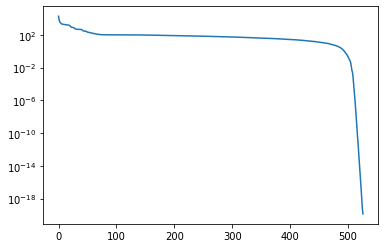

In [9]:
plt.semilogy(history)